# Tuning Book for NREL 5MW Turbine

In [ ]:
# Introduction notes

In [25]:
# Tune NREL 5MW Turbine
# Needed Modules
%matplotlib inline
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import cPickle as pickle
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [19]:
# Imports from openmdao
from openmdao.api import Problem, Group, IndepVarComp
# from pyoptsparse import Optimization, OPT, SNOPT


In [3]:
# Imports from FLORIS
from florisse.floris import DirectionGroup
from florisse import config

In [17]:
#QUESTIONS FOR JARED
###
# 1) What is the purpose of the global variables?
# 2) Why use smooth versus flat
###

In [22]:
# Load the SOWFA data sets
yawPos,avPowersYaw, yawPosI2,avPowersYawI2 = pickle.load( open( os.path.join('data','yawPower.p'), "rb" ) )
spacing,avPowersSpace = pickle.load( open( os.path.join('data','spacePower.p'), "rb" ) )
offset4D,avPowersOffset4D = pickle.load( open( os.path.join('data','offset4DPower.p'), "rb" ) )
offset6D,avPowersOffset6D = pickle.load( open( os.path.join('data','offset6DPower.p'), "rb" ) )

In [12]:
## Set FLORIS parameters for this case

model = 'smooth'  # options: 'original', 'smooth'
gradients = 'fd'    # options: 'fd', 'exact'
flat = True        # if False, will use cosine smoothing factor
rotor = True       # if True, will use rotor coupled data
tune = False        # if True, will optimize parameters starting with provided values

if model == 'smooth':
    differentiable = True
else:
    differentiable = False


In [5]:
## Set models for FLORIS parameters

# power
pP = 1.88   # control Cp adjustment to yaw

# deflection
kd = 0.15                       # adjust yaw deflection
# global initialWakeDisplacement
initialWakeDisplacement = -4.5  # initial rotational displacement
bd = -0.01                      # continued deflection from rotation as separation increases
# initialWakeAngle = 0.5*3.0
initialWakeAngle = 1.5

# expansion
ke = 0.065                          # adjust overall rate of wake expansion
# global me
me = np.array([-0.5, 0.22, 1.0])    # adjust individual wake expansion

# velocity
#global MU
MU = np.array([0.5, 1.0, 5.5])      # zone velocity deficit decay rate

aU = 5.0                            # offset in decay adjustment
bU = 1.66                           # parameter of yaw on decay adjustment
cos_spread = 1e12                   # additional deficit based on crosswind relative location

In [6]:
# Load the Cp table for NREL 5MW
NREL5MWCPCT = pickle.load(open('../NREL5MWCPCT_smooth_dict.p'))
datasize = NREL5MWCPCT['CP'].size
# These are arrays of CP and CT versus wind speed
NREL5MWCPCT

{'CP': array([ 0.        ,  0.15643578,  0.31287155,  0.41306749,  0.44895632,
         0.46155227,  0.46330747,  0.46316077,  0.46316077,  0.46280642,
         0.45223111,  0.39353012,  0.3424487 ,  0.2979978 ,  0.25931677,
         0.22565665,  0.19636572,  0.17087684,  0.1486965 ,  0.12939524,
         0.11259934,  0.0979836 ,  0.08526502,  0.07419736,  0.06456631,
         0.05618541,  0.04889237,  0.        ]),
 'CT': array([ 1.10610965,  1.09515807,  1.0227122 ,  0.9196487 ,  0.8519047 ,
         0.80328229,  0.76675469,  0.76209299,  0.76209299,  0.75083241,
         0.67210674,  0.52188504,  0.43178758,  0.36443258,  0.31049874,
         0.26696686,  0.22986909,  0.19961578,  0.17286245,  0.15081457,
         0.13146666,  0.11475968,  0.10129584,  0.0880188 ,  0.07746819,
         0.06878621,  0.05977061,  0.        ]),
 'wind_speed': array([  0.        ,   2.5       ,   3.52338654,   4.57015961,
          5.61693268,   6.66370575,   7.71047882,   8.75725189,
          9.804024

In [7]:
# initialize input variable arrays
nTurbines = 2
rotorDiameter = np.zeros(nTurbines)
axialInduction = np.zeros(nTurbines)
Ct = np.zeros(nTurbines)
Cp = np.zeros(nTurbines)
generatorEfficiency = np.zeros(nTurbines)
yaw = np.zeros(nTurbines)


In [8]:
# define initial values
for turbI in range(0, nTurbines):
    rotorDiameter[turbI] = 126.4            # m
    axialInduction[turbI] = 1.0/3.0
    Ct[turbI] = 4.0*axialInduction[turbI]*(1.0-axialInduction[turbI])
    Cp[turbI] = (0.7737/0.944) * 4.0 * 1.0/3.0 * np.power((1. - 1.0/3.0), 2)
    generatorEfficiency[turbI] = 0.944
    yaw[turbI] = 0.     # deg.
print "initial Cp", Cp
print "initial Ct", Ct


initial Cp [ 0.48568738  0.48568738]
initial Ct [ 0.88888889  0.88888889]


In [9]:
# Inflow conditions
wind_speed = 8.1
air_density = 1.1716 
wind_direction = 270.-0.523599*180./np.pi 
wind_direction

239.9999871427296

In [10]:
# Definte the FLORIS model within openmdao

global prob
prob = Problem(root=Group())


In [13]:
# Add a FLORIS model
prob.root.add('FLORIS', DirectionGroup(nTurbines, use_rotor_components=rotor,
                                           datasize=datasize, differentiable=differentiable), promotes=['*'])

In [14]:
# set up problem
prob.setup(check=False)

{}

In [16]:
# Add Cp-Ct information
if rotor:
    prob['gen_params:windSpeedToCPCT_CP'] = NREL5MWCPCT['CP']
    prob['gen_params:windSpeedToCPCT_CT'] = NREL5MWCPCT['CT']
    prob['gen_params:windSpeedToCPCT_wind_speed'] = NREL5MWCPCT['wind_speed']
    prob['floris_params:useWakeAngle'] = True
    prob['floris_params:adjustInitialWakeDiamToYaw'] = False
    prob['floris_params:axialIndProvided'] = False
    prob['floris_params:useaUbU'] = True

In [17]:
# Assign all neccessary FLORIS parameters
prob['gen_params:pP'] = pP
prob['floris_params:kd'] = kd
prob['floris_params:initialWakeAngle'] = initialWakeAngle
prob['floris_params:initialWakeDisplacement'] = initialWakeDisplacement
prob['floris_params:bd'] = bd
prob['floris_params:ke'] = ke
prob['floris_params:me'] = me
prob['floris_params:MU'] = MU
prob['floris_params:aU'] = aU
prob['floris_params:bU'] = bU
prob['floris_params:cos_spread'] = cos_spread
prob['rotorDiameter'] = rotorDiameter
prob['axialInduction'] = axialInduction
prob['generatorEfficiency'] = generatorEfficiency
prob['wind_speed'] = wind_speed
prob['air_density'] = air_density
prob['wind_direction'] = wind_direction

### Compare to 4D yaw powers

In [52]:
# Set the turbine positions
prob['turbineX'] = np.array([1118.1, 1556.0])
prob['turbineY'] = np.array([1279.5, 1532.3])
FLORISpower = list()
for yaw1 in yawPos:
    prob['yaw0'] = np.array([yaw1, 0.0])
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

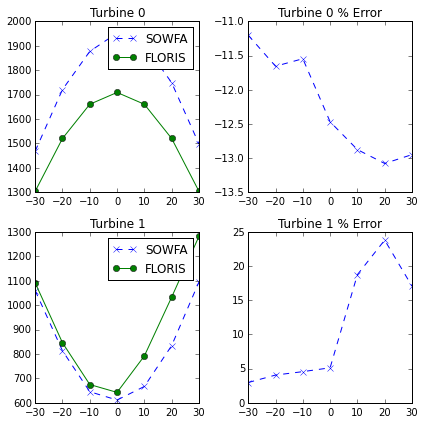

In [53]:
# Compare the power
fig, axarr = plt.subplots(2,2,figsize=(6,6))

# Plot turbine 0
ax = axarr[0,0]
ax.plot(yawPos,avPowersYaw[:,0]/1000.,'x--',label='SOWFA')
ax.plot(yawPos,FLORISpower[:,0],'o-',label='FLORIS')
ax.set_title('Turbine 0')
ax.legend()

ax = axarr[0,1]
ax.plot(yawPos,100 * (FLORISpower[:,0] - avPowersYaw[:,0]/1000.)/(avPowersYaw[:,0]/1000.),'x--',label='SOWFA')
ax.set_title('Turbine 0 % Error')

# Plot turbine 1
ax = axarr[1,0]
ax.plot(yawPos,avPowersYaw[:,1]/1000.,'x--',label='SOWFA')
ax.plot(yawPos,FLORISpower[:,1],'o-',label='FLORIS')
ax.set_title('Turbine 1')
ax.legend()

ax = axarr[1,1]
ax.plot(yawPos,100 * (FLORISpower[:,1] - avPowersYaw[:,1]/1000.)/(avPowersYaw[:,1]/1000.),'x--',label='SOWFA')
ax.set_title('Turbine 1 % Error')

In [47]:
### Compare to 7D (ICOWES2) yaw powers

In [50]:
prob['turbineX'] = np.array([1118.1, 1881.9])
prob['turbineY'] = np.array([1279.5, 1720.5])
FLORISpower = list()
for yaw1 in yawPosI2:
    prob['yaw0'] = np.array([yaw1, 0.0])
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

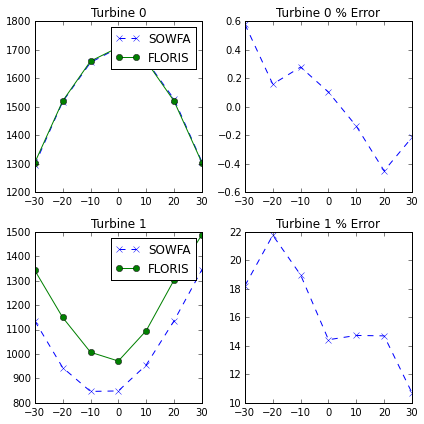

In [51]:
# Compare the power
fig, axarr = plt.subplots(2,2,figsize=(6,6))

# Plot turbine 0
ax = axarr[0,0]
ax.plot(yawPos,avPowersYawI2[:,0]/1000.,'x--',label='SOWFA')
ax.plot(yawPos,FLORISpower[:,0],'o-',label='FLORIS')
ax.set_title('Turbine 0')
ax.legend()

ax = axarr[0,1]
ax.plot(yawPos,100 * (FLORISpower[:,0] - avPowersYawI2[:,0]/1000.)/(avPowersYawI2[:,0]/1000.),'x--',label='SOWFA')
ax.set_title('Turbine 0 % Error')

# Plot turbine 1
ax = axarr[1,0]
ax.plot(yawPos,avPowersYawI2[:,1]/1000.,'x--',label='SOWFA')
ax.plot(yawPos,FLORISpower[:,1],'o-',label='FLORIS')
ax.set_title('Turbine 1')
ax.legend()

ax = axarr[1,1]
ax.plot(yawPos,100 * (FLORISpower[:,1] - avPowersYawI2[:,1]/1000.)/(avPowersYawI2[:,1]/1000.),'x--',label='SOWFA')
ax.set_title('Turbine 1 % Error')

In [54]:
spacing,avPowersSpace

([2, 4, 6, 8, 10], array([[ 1903928.33500838,   411080.5958299 ],
        [ 1952278.87249681,   611342.4559564 ],
        [ 1965798.28295707,   807479.78045201],
        [ 1971041.71296782,   958477.27030176],
        [ 1973661.40318508,  1092063.69732993]]))